<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4662 entries, 0 to 4661
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4662 non-null   object 
 1   High       4662 non-null   float64
 2   Low        4662 non-null   float64
 3   Open       4662 non-null   float64
 4   Close      4662 non-null   float64
 5   Adj Close  4662 non-null   float64
 6   count      4662 non-null   float64
dtypes: float64(6), object(1)
memory usage: 255.1+ KB


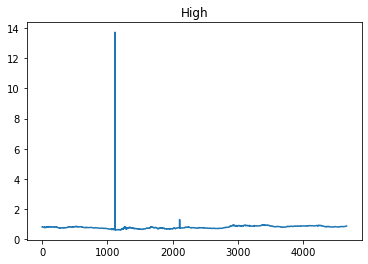

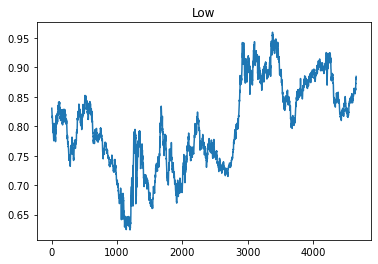

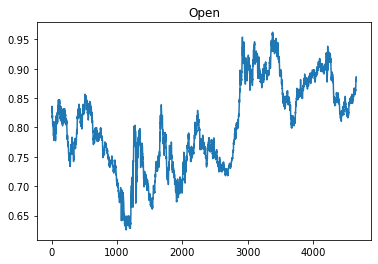

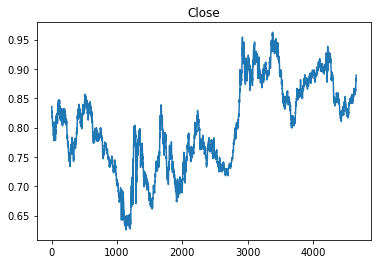

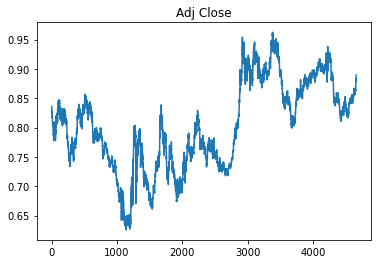

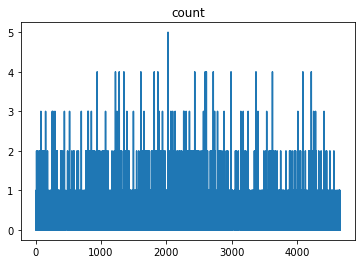

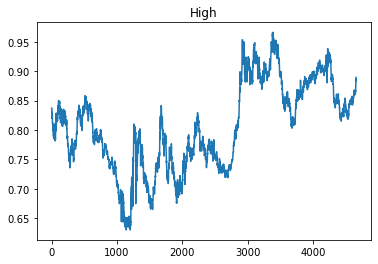

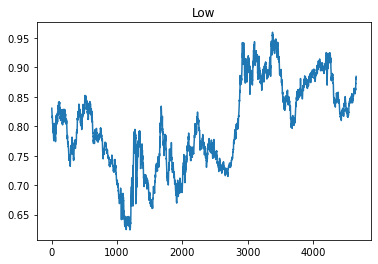

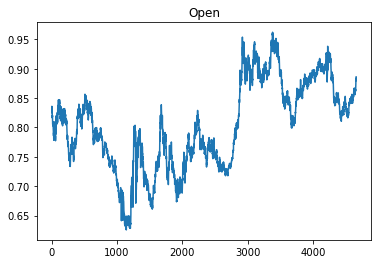

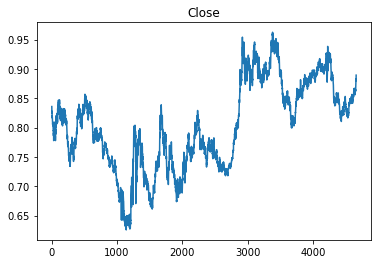

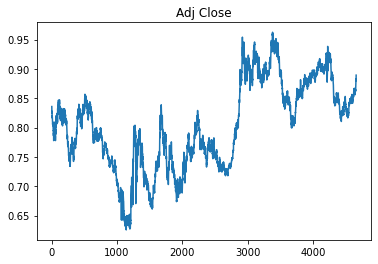

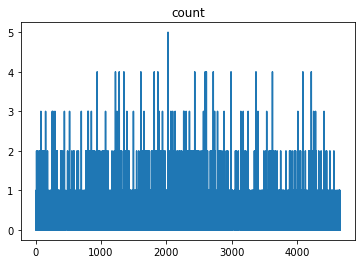

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data_collection/data.csv")

df.head()

df.drop("Volume",1,inplace=True)

df.info()

for i in df.columns[1:]:
    df[i].plot()
    plt.title(i)
    plt.show()
    

df.drop(df[df.High > 1].index, inplace=True)

for i in df.columns[1:]:
    df[i].plot()
    plt.title(i)
    plt.show()
    

In [12]:
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = df[["Close"]].iloc[:-20]
X_test = df[["Close"]].iloc[-20:]
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

In [60]:
n_input = 120
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [61]:
X,y = generator[0]
print(f'Given the Array: \n{X.shape}')
print(f'Predict this y: \n {y.shape}')

Given the Array: 
(1, 120, 1)
Predict this y: 
 (1, 1)


In [82]:
len(generator)

4520

In [84]:
xt = []
for i in generator:
    X,y = i
    xt.append(X)

In [95]:
xt = np.array(xt).reshape(4520, 120, 1)

In [62]:
model = Sequential()
model.add(LSTM(240, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(120, activation='relu'))
model.add(Dense(30, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 240)          232320    
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               173280    
_________________________________________________________________
dense (Dense)                (None, 30)                3630      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 409,261
Trainable params: 409,261
Non-trainable params: 0
_________________________________________________________________


In [64]:
es_callback = EarlyStopping(monitor="loss", patience=5)

In [65]:
tf.keras.backend.clear_session()
history = model.fit_generator(
    generator,
    epochs=100,
    callbacks=[es_callback],
)

C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
4520/4520 [==============================] - 285s 63ms/step - loss: 0.0077
Epoch 2/100
4520/4520 [==============================] - 330s 73ms/step - loss: 0.0031
Epoch 3/100
4520/4520 [==============================] - 314s 69ms/step - loss: 0.0028
Epoch 4/100
4520/4520 [==============================] - 337s 75ms/step - loss: 0.0025
Epoch 5/100
4520/4520 [==============================] - 367s 81ms/step - loss: 0.0024
Epoch 6/100
4520/4520 [==============================] - 347s 77ms/step - loss: 0.0024
Epoch 7/100
4520/4520 [==============================] - 325s 72ms/step - loss: 0.0023
Epoch 8/100
4520/4520 [==============================] - 316s 70ms/step - loss: 0.0022
Epoch 9/100
4520/4520 [==============================] - 345s 76ms/step - loss: 0.0023
Epoch 10/100
4520/4520 [==============================] - 320s 71ms/step - loss: 0.0022
Epoch 11/100
4520/4520 [==============================] - 333s 74ms/step - loss: 0.0023
Epoch 12/100
4520/4520 [=================

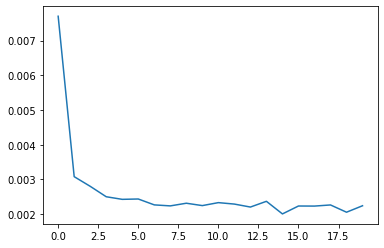

In [66]:
plt.plot(history.history["loss"])

In [67]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(X_test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [68]:
true_predictions = scaler.inverse_transform(pd.DataFrame(test_predictions))
X_test['Predictions'] = true_predictions 

<AxesSubplot:>

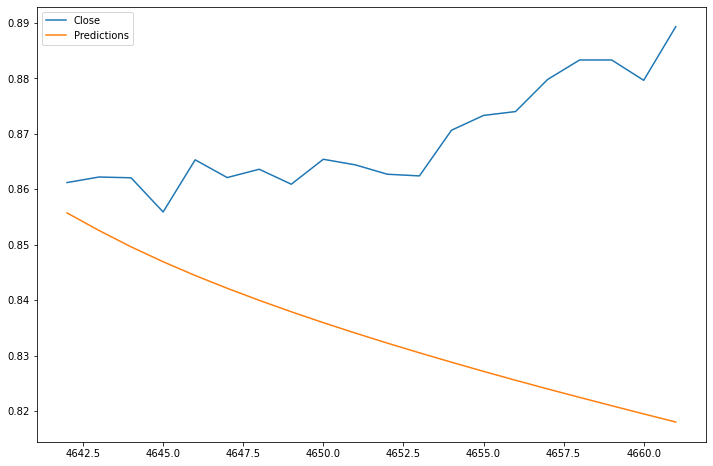

In [69]:
X_test.plot(figsize=(12,8))

In [97]:
train_predictions= model.predict(xt)
true_predictions = scaler.inverse_transform(pd.DataFrame(train_predictions))

In [102]:
len(X_train) - len(true_predictions)

120

<AxesSubplot:>

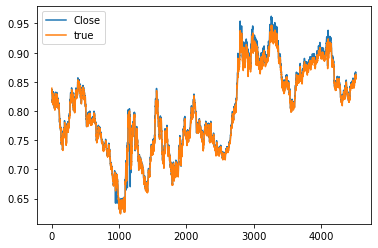

In [105]:
pt = X_train.iloc[120:].reset_index().drop("index",1)
pt["true"] = true_predictions
pt.plot()